In [64]:
# Exporting UNet from Pytorch to ONNX format.

## Load the pre-trained model

In [65]:
import torch 
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/kostas84/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## Create a random input tensor

In [66]:
input = torch.randn(1, 3, 256, 256)

## Export model to onnx format

In [67]:
torch.onnx.export(net, 
                  input,
                  "unet.onnx",
                  input_names=["input"],
                  output_names=["output"])

## Verify ONNX Model

In [68]:
import onnxruntime as ort

model = ort.InferenceSession("unet.onnx")

print("Input names:", model.get_inputs()[0].name)
print("Output names:", model.get_outputs()[0].name)

Input names: input
Output names: output


## Verification Using Netron

<img src="input_unet.png"  width="1000" height="400">

<img src="output_unet.png"  width="1000" height="400">

Implementing UNet on the CPU involves severar implementation steps

- Preparation of the input tensor (pre-proceccing)
- Performing an inference in the CPU accelerator
- Post-processing
- Visualization 

In [69]:
import numpy as np
import cv2 

def preprocessing(image): 
    

    img = cv2.resize(image, (256, 256))
    img = np.transpose(img, [2, 0, 1])
    img = np.asarray(img, np.float32) 
    img = np.expand_dims(img, axis=0)
    
    return img


img = "elephant.jpg"
original_img = cv2.imread(img)
img = preprocessing(original_img)


In [70]:
import onnxruntime as ort

session_options = ort.SessionOptions()
session = ort.InferenceSession("unet.onnx", session_options, ["CPUExecutionProvider"])


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
ortvalue = ort.OrtValue.ortvalue_from_numpy(img)
output_sess = session.run([output_name], {input_name:ortvalue})[0]

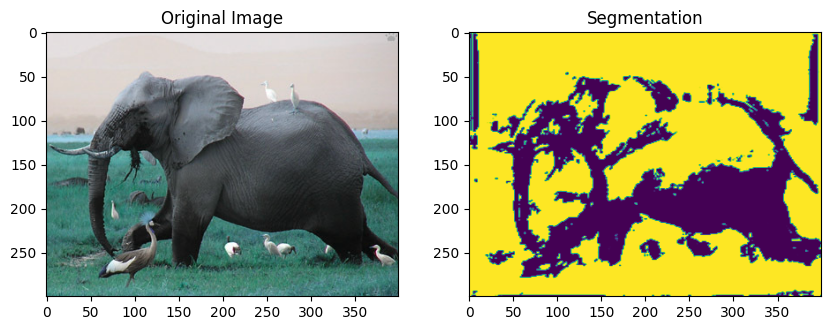

In [71]:
import matplotlib.pyplot as plt


def postprocessing(output, image):
    
    image = image.shape
    
    # removing bacth dim BCHW -> CHW
    output = output.squeeze(0) 
    # Converting CHW -> HWC
    output = output.transpose(1, 2, 0)    
    # resizing output to the original shape dims 
    output = cv2.resize(output, (image[1], image[0]))
    
   
    
    return output


def unet_imshow(mask, original_img):
    
    
    plt.figure(figsize=(10, 8))
    plt.subplot(1,2,1)
    
    plt.title("Original Image")
    plt.imshow(original_img)
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation")
    plt.imshow(mask)
    
    plt.show()
    
    
segm_mask = postprocessing(output_sess, original_img)


unet_imshow(segm_mask, original_img)
    